In [1]:
try:
    import pyforest
except:
    !pip install pyforest
    import pyforest

Processing /home/jovyan/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893/pyforest-1.1.0-py2.py3-none-any.whl


The first step is to import the nedded dataset. In our case these are the acquired VOC measurements from three different substances (wine, garlic, vinegar). The temperature range is 200°C - 400°C with a step size of 5°C between each datapoint.

Two different sensors were used to take the measurements, named sensor 2 and sensor 3.

In [5]:
df = pd.read_csv('../datasets/dataset_wine_garlic_vinegar.csv').set_index('series')
X = df.drop(['Class', 'Sensor'], axis = 1)
y = df['Class']
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After the import, the dataset need to be split into a train, a validate and a test dataset. The validation will always be performed with a k-fold cross validation.
You have three different choices for the train-test-split:

- random split with a 70% train and 30% test separation (split_mode = 'random')
- using the datapoints from sensor 2 as training set (split_mode = 'sensor2')
- using the datapoints from sensor 3 as training set (split_mode = 'sensor3')

In [6]:
split_mode = 'random'

In [7]:
from lib.sensor_split import two_sensor_split

if split_mode == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
elif split_mode == 'sensor2':
    X_train, X_test, y_train, y_test = two_sensor_split(df, train_sensor = 2, test_sensor = 3)
elif split_mode == 'sensor3':
    X_train, X_test, y_train, y_test = two_sensor_split(df, train_sensor = 3, test_sensor = 2)

<IPython.core.display.Javascript object>

The next step is the classification pre-processing. Here a normalization is performed.
Furthemore a feature reduction algorithm can be applied, here again there are two different possibilities:

- a Principal Component Analysis (PCA) in order to create n features
- a feature selection algorithm, in order to identify the n features with highest covariance.

It is important, that the following steps are only performed on the training set! The so obtained models will be applied at the very end of the classification process to the test dataset in order to evaluate the classification performance.

In [8]:
pca_dim = 2

In [9]:
scaler= MinMaxScaler()
X_train = scaler.fit_transform(X_train)

if pca_dim:
    pca = PCA(n_components = pca_dim)
    X_train = pca.fit_transform(X_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now the classification part itself finally takes place. There are many different classifiers and ways to manipulate the hyperparameters, so feel free to adapt the code to your own wishes!

In [10]:
#classifier = RandomForestClassifier()
#classifier = SVC(kernel = 'rbf', C = 1)
#classifier = KNeighborsClassifier(**{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'})
classifier = LogisticRegression(**{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'})
#classifier = SVC(**{'C': 100, 'kernel': 'rbf'})
#classifier = SVC(kernel = 'linear', C = 1)

classifier.fit(X_train, y_train)

<IPython.core.display.Javascript object>

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

The trained models are now all applied to the test dataset and the results are evaluated.

In [11]:
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score

X_test = scaler.transform(X_test)
X = scaler.transform(X)

if pca_dim:
        X_test = pca.transform(X_test)
        X = pca.transform(X)
    
y_pred = classifier.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, y_pred)
matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')

print(matrix)
print(f1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[170  10   2]
 [ 17  80   4]
 [  0   0 146]]
0.9129904403275853


If you want to visualize the results:
(Only possible if a two dimensional feature reducation was applied)

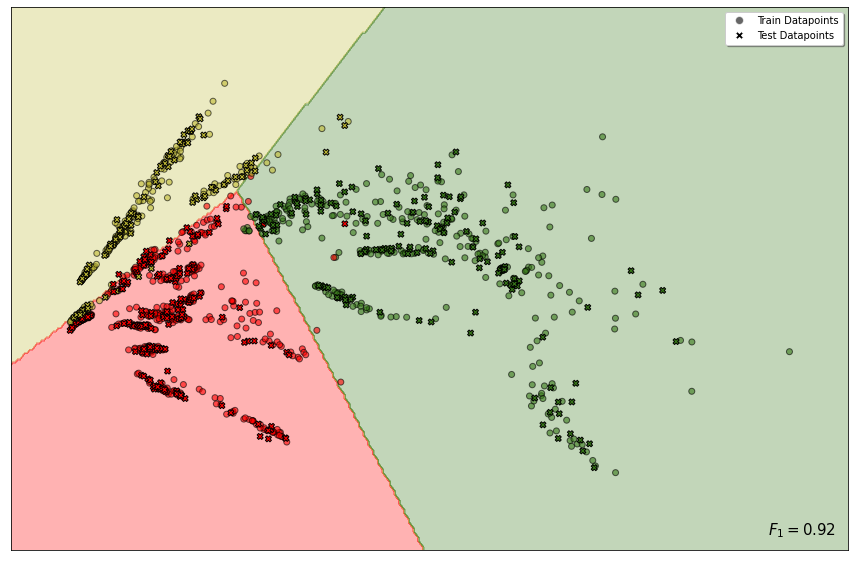

In [12]:
from lib.plot import decision_boundaries_2d

if pca_dim == 2:
    decision_boundaries_2d(X, classifier, X_train, X_test, y_train, y_test, score)
else:
    print('Please use a lower feature dimensionality in order to visualize the classification boundaries')

If you want to save the models for later re-use:

If you want to export the obtained results: